**Bitcoin Price Prediction using Multivariate Data**

About this Notebook

*   Sources: https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/ , https://www.geeksforgeeks.org/principal-component-analysis-with-python/ , various other blogs and python notebook

About the Dataset


*   Source: https://www.cryptodatadownload.com/

**The goal is to use 50 ticks of 1 minute multivariate bitcoin data to predict the next 15 minute through a Recurrent Encoder Decoder model.** 

Steps followed:


1.   Load dataset
2.   Build features (new features are financial indicators)
3.   Select last 5k rows and divide it in train_set and test_set
4.   Normalize dataset and build X_train, X_test, y_train, y_test
5.   (Remember that X_train, X_test, y_train and y_test need to be in the shape [n_samples, n_timesteps, n_features] )
6.   Init the model and train it
7.   Predict data on X_test and reverse normalization
8.   Compare results with y_test

In [1]:
# NOTE: to predict just 1 sequence of n future vectors (one vector would be one tick with all features) you'll need to respect those requirements:
#  n_vectors to predict = n_future
#  test_set[n_samples, features] => n_samples = n_past + n_future
#  In this way in the test_set you can use the first n_past tick to predict the n_future tick
#  if n_samples > n_past + n_future the model will predict a number of sequence of n_future vectors equal to the that difference (n_sequence = n_samples - n_past - n_future)
#         which won't be very useful because only the last one will have all n_future vectors to predict 
#         (the other ones will predict some vector of which you already know all the values)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [4]:
#--------------------- Data Preprocessing --------------------#
# Importing and scaling the data
#dataset_train = pd.read_csv("Bitcoin_Stock_Price_Trainset.csv")
dataset = pd.read_csv('https://github.com/danber93/multivariate_lstm_encoder_decoder_prediction/blob/main/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
dataset = dataset.iloc[::-1]
print(dataset.shape)
dataset

(330483, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
330482,1599856800000,2020-09-11 20:40:00,BTC/USDT,10317.00,10317.01,10314.36,10316.00,32.997684,3.403985e+05,342
330481,1599856860000,2020-09-11 20:41:00,BTC/USDT,10316.00,10321.09,10316.00,10319.50,16.328427,1.684977e+05,256
330480,1599856920000,2020-09-11 20:42:00,BTC/USDT,10319.50,10320.31,10318.49,10319.34,12.123487,1.251089e+05,193
330479,1599856980000,2020-09-11 20:43:00,BTC/USDT,10319.34,10320.14,10318.89,10319.00,13.548103,1.398070e+05,187
330478,1599857040000,2020-09-11 20:44:00,BTC/USDT,10318.99,10319.72,10316.58,10319.47,14.466964,1.492667e+05,284
...,...,...,...,...,...,...,...,...,...,...
4,1619742660000,2021-04-30 00:31:00,BTC/USDT,53745.99,53816.36,53700.00,53780.39,169.848725,9.132947e+06,2568
3,1619742720000,2021-04-30 00:32:00,BTC/USDT,53780.39,53784.04,53674.52,53674.53,53.895245,2.895554e+06,1595
2,1619742780000,2021-04-30 00:33:00,BTC/USDT,53674.53,53691.13,53615.98,53677.39,81.940577,4.396348e+06,1621
1,1619742840000,2021-04-30 00:34:00,BTC/USDT,53677.39,53722.40,53564.00,53580.98,89.941874,4.823830e+06,1777


In [5]:
# Building features
dataset['diff_pct_1'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(1)))) * 100) - 100
dataset['diff_pct_5'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(5)))) * 100) - 100
dataset['diff_pct_15'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(15)))) * 100) - 100
dataset['diff_pct_22'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(22)))) * 100) - 100

print(dataset.columns)
print(dataset)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'diff_pct_1', 'diff_pct_5', 'diff_pct_15',
       'diff_pct_22'],
      dtype='object')
                 unix                 date  ... diff_pct_15  diff_pct_22
330482  1599856800000  2020-09-11 20:40:00  ...  -80.610929   -80.668779
330481  1599856860000  2020-09-11 20:41:00  ...  -80.614771   -80.676393
330480  1599856920000  2020-09-11 20:42:00  ...  -80.616688   -80.629481
330479  1599856980000  2020-09-11 20:43:00  ...  -80.588182   -80.576585
330478  1599857040000  2020-09-11 20:44:00  ...  -80.618006   -80.559402
...               ...                  ...  ...         ...          ...
4       1619742660000  2021-04-30 00:31:00  ...    0.951619     0.988622
3       1619742720000  2021-04-30 00:32:00  ...    1.031367     0.657491
2       1619742780000  2021-04-30 00:33:00  ...    1.121528     0.577845
1       1619742840000  2021-04-30 00:34:00  ...    0.856189     0.4

In [6]:
# Drop useless columns

print(dataset.columns)
dataset = dataset.drop(['unix', 'date', 'symbol', 'Volume BTC', 'Volume USDT', 'open', 'low', 'high', 'tradecount'], axis=1)
print(dataset)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'diff_pct_1', 'diff_pct_5', 'diff_pct_15',
       'diff_pct_22'],
      dtype='object')
           close  diff_pct_1  diff_pct_5  diff_pct_15  diff_pct_22
330482  10316.00  -80.728524  -80.818287   -80.610929   -80.668779
330481  10319.50    0.033928  -80.773935   -80.614771   -80.676393
330480  10319.34   -0.001550  -80.775258   -80.616688   -80.629481
330479  10319.00   -0.003295  -80.741300   -80.588182   -80.576585
330478  10319.47    0.004555  -80.722041   -80.618006   -80.559402
...          ...         ...         ...          ...          ...
4       53780.39    0.063986    0.839126     0.951619     0.988622
3       53674.53   -0.196838    0.549576     1.031367     0.657491
2       53677.39    0.005328    0.427962     1.121528     0.577845
1       53580.98   -0.179610   -0.077318     0.856189     0.439316
0       53529.89   -0.095351   -0.402095     0.636797     0.

In [7]:
# Select last  5k rows
dataset = dataset.tail(5000)

# Split into train and test dataset
dataset_train, dataset_test = dataset[1:4936], dataset[4935:]
print(dataset_train.shape)
print(dataset_test.shape)
dataset_train = pd.DataFrame(dataset_train)
dataset_test = pd.DataFrame(dataset_test)

(4935, 5)
(65, 5)


In [8]:
# Function to build X_train, X_test, y_train and y_test in the shape [n_samples, n_timesteps, n_features]

def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [9]:
n_past = 50
n_future = 15
n_features = 5

In [10]:
train = dataset_train
scalers={}
for i in dataset_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = dataset_test
for i in dataset_test.columns:
    scaler = scalers['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    test[i]=s_s
print(test.shape)

(65, 5)


In [11]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (4871, 50, 5)
X_test.shape (1, 50, 5)
y_train.shape (4871, 15, 5)
y_test.shape (1, 15, 5)


In [12]:
# Select only close feature from y_train and y_test

y_train = y_train[:, :, 3:4]
y_test = y_test[:, :, 3:4]

print(y_train.shape)
print(y_test.shape)

X_train = X_train[:, :, 1:5]
X_test = X_test[:, : , 1:5]

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

(4871, 15, 1)
(1, 15, 1)
X_train.shape (4871, 50, 4)
X_test.shape (1, 50, 4)


In [13]:
# Encoder Decoder LSTM
# n_features ==> no of features at each timestep in the data.
#

dropout = 0.2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, X_train.shape[2]))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True, dropout=dropout)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True, dropout=dropout)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_test.shape[2]))(decoder_l1)

#
model= tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42000       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 15, 100)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 100)      80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [14]:
filepath = '/content/checkpoint_2/model{epoch:d}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    period = 5)

In [15]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.LogCosh()) #Huber
history=model.fit(X_train,y_train,epochs=60,validation_data=(X_test,y_test),batch_size=64,verbose=1,callbacks=[checkpoint, reduce_lr])

Epoch 1/60
77/77 [==============================] - 7s 33ms/step - loss: 0.0055 - val_loss: 0.0227
Epoch 2/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0047 - val_loss: 0.0211
Epoch 3/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0046 - val_loss: 0.0285
Epoch 4/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0045 - val_loss: 0.0257
Epoch 5/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0045 - val_loss: 0.0223


INFO:tensorflow:Assets written to: /content/checkpoint_2/model5/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model5/assets


Epoch 6/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0045 - val_loss: 0.0218
Epoch 7/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0043 - val_loss: 0.0224
Epoch 8/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0225
Epoch 9/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0173
Epoch 10/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0043 - val_loss: 0.0202


INFO:tensorflow:Assets written to: /content/checkpoint_2/model10/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model10/assets


Epoch 11/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0185
Epoch 12/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0184
Epoch 13/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0166
Epoch 14/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0199
Epoch 15/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0178


INFO:tensorflow:Assets written to: /content/checkpoint_2/model15/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model15/assets


Epoch 16/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0044 - val_loss: 0.0200
Epoch 17/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0195
Epoch 18/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0183
Epoch 19/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0200
Epoch 20/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0189


INFO:tensorflow:Assets written to: /content/checkpoint_2/model20/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model20/assets


Epoch 21/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0188
Epoch 22/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0189
Epoch 23/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0189
Epoch 24/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0197
Epoch 25/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0184


INFO:tensorflow:Assets written to: /content/checkpoint_2/model25/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model25/assets


Epoch 26/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0196
Epoch 27/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0189
Epoch 28/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0192
Epoch 29/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0183
Epoch 30/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0187


INFO:tensorflow:Assets written to: /content/checkpoint_2/model30/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model30/assets


Epoch 31/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0187
Epoch 32/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0187
Epoch 33/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 34/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0189
Epoch 35/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0190


INFO:tensorflow:Assets written to: /content/checkpoint_2/model35/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model35/assets


Epoch 36/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0191
Epoch 37/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0192
Epoch 38/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0192
Epoch 39/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0195
Epoch 40/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0194


INFO:tensorflow:Assets written to: /content/checkpoint_2/model40/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model40/assets


Epoch 41/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0196
Epoch 42/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0195
Epoch 43/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0191
Epoch 44/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0192
Epoch 45/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0191


INFO:tensorflow:Assets written to: /content/checkpoint_2/model45/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model45/assets


Epoch 46/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0041 - val_loss: 0.0192
Epoch 47/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 48/60
77/77 [==============================] - 2s 22ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 49/60
77/77 [==============================] - 2s 22ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 50/60
77/77 [==============================] - 2s 22ms/step - loss: 0.0040 - val_loss: 0.0193


INFO:tensorflow:Assets written to: /content/checkpoint_2/model50/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model50/assets


Epoch 51/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0192
Epoch 52/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0192
Epoch 53/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0192
Epoch 54/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 55/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0194


INFO:tensorflow:Assets written to: /content/checkpoint_2/model55/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model55/assets


Epoch 56/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 57/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 58/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0193
Epoch 59/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193
Epoch 60/60
77/77 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0193


INFO:tensorflow:Assets written to: /content/checkpoint_2/model60/assets


INFO:tensorflow:Assets written to: /content/checkpoint_2/model60/assets


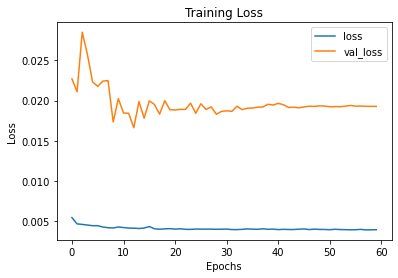

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [17]:
# Make the prediction

pred=model.predict(X_test)
print(pred.shape)

(1, 15, 1)


In [18]:
# Reverse normalized transformation

scaler = scalers['scaler_close']
pred[:,:,0]=scaler.inverse_transform(pred[:,:,0])

print(pred.shape)
print(pred)

(1, 15, 1)
[[[54231.816]
  [54248.375]
  [54260.984]
  [54274.22 ]
  [54290.914]
  [54312.598]
  [54339.758]
  [54372.008]
  [54408.26 ]
  [54446.918]
  [54486.035]
  [54523.527]
  [54557.383]
  [54585.8  ]
  [54607.363]]]


In [19]:
y_test[:, :, 0] = scalers["scaler_close"].inverse_transform(y_test[:,:,0])
print(y_test)

[[[54239.10763496]
  [54343.79284206]
  [54395.77005015]
  [54392.82150149]
  [54410.57621457]
  [54466.6704977 ]
  [54554.2127494 ]
  [54572.43768009]
  [54830.92417671]
  [54935.16109667]
  [55140.32714481]
  [55193.03066047]
  [55252.61613826]
  [55077.25967646]
  [54932.2686325 ]]]


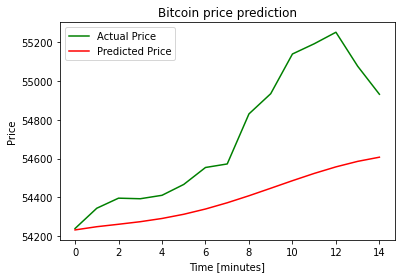

In [20]:
plt.plot(y_test[:, :, 0].flatten(), label="Actual Price", color='green')
plt.plot(pred[:, :, 0].flatten(), label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [minutes]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

If you find any error or if you have any question please email me at daniele.bertillo@gmail.com